## Completion finetuning using unsloth

This notebook makes use of unsloth to finetune a model for a completion task.
In this example we will finetune the llama 3.2 base model to generate domains given a business description.

In [29]:
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3  peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer seaborn matplotlib wandb
!pip install --no-deps unsloth

In [32]:
from google.colab import userdata
import os
import wandb

BASE_MODEL = "meta-llama/Llama-3.2-3B"
PROJECT_NAME = "domains-iteration-2"
HF_USER = "pashko-bond"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_NAME}"

wandb_api_key = userdata.get('WANDB_API_KEY')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint"
os.environ["WANDB_WATCH"] = "gradients"

### Load base model

In [2]:
from unsloth import FastLanguageModel
import torch


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="meta-llama/Llama-3.2-3B",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
    token=userdata.get('HF_TOKEN')
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [3]:
print(f"Memory footprint: {model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 2327.7 MB


### Add lora to base model and patch with Unsloth

In [4]:
# More info about parameters: https://huggingface.co/docs/peft/v0.11.0/en/package_reference/lora#peft.LoraConfig
target_modules =  ["q_proj", "k_proj", "v_proj", "o_proj"
                   ,"gate_proj", "up_proj", "down_proj"]

model = FastLanguageModel.get_peft_model(
    model,
    r = 8,  # or 16 rank of lora matrices according to paper not much loss when set relatively low
    target_modules = target_modules,  # On which modules of the llm the lora weights are used
    lora_alpha = 8, # scales the weights of the adapters (more influence on base model), 16 was recommended on reddit
    lora_dropout = 0, # unsloth says 0 is better
    bias = "none",    # "none" is optimized
    use_gradient_checkpointing = "unsloth", #"unsloth" for very long context, decreases vram
    random_state = 3407,
    use_rslora = False,  # scales lora_alpha with 1/sqrt(r), huggingface says this works better
    loftq_config = None, # And LoftQ
)

Unsloth 2025.6.12 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [23]:
import json
import pandas as pd
from datasets import Dataset
from unsloth.chat_templates import get_chat_template

LOCAL_TRAINING_JSON = "data.json"

# Prepare tokenizer with the appropriate chat template
tokenizer = get_chat_template(tokenizer, chat_template="llama-3.2")

def process_output(output):
    if isinstance(output, list):
        return '\n'.join(output)
    elif isinstance(output, str):
        return output
    else:
        return str(output)

def create_conversations(data, isTesting=False):
    return [
        [
            {
                "role": "system",
                "content": "You are a creative assistant that suggests catchy domain names for businesses."
            },
            {
                "role": "user",
                "content": f"Generate 3-5 creative and memorable domains for {item['business_description']}"
            },
        ] + (
            [] if isTesting else [{
                "role": "assistant",
                "content": process_output(item['output'])
            }]
        )
        for item in data
    ]

def format_prompt(convos, tokenizer):
    texts = [
        tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False)
        for convo in convos
    ]
    return {"text": texts}

with open(LOCAL_TRAINING_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

split_idx = int(len(data) * 0.9)
train_raw = data[:split_idx]
testing_dataset = data[split_idx:]

# Then create conversations from each split
train_convos = [create_conversations([item])[0] for item in train_raw]

# Format
formatted_train = format_prompt(train_convos, tokenizer)
# Wrap into Hugging Face datasets
training_dataset = Dataset.from_dict(formatted_train)


print(f"Loaded {len(training_dataset)} training examples")
print("\nExample formatted text for training:")
print(training_dataset[0]['text'])
print("\nExample formatted text for testing (no assistant):")

Loaded 550 training examples

Example formatted text for training:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

You are a creative assistant that suggests catchy domain names for businesses.<|eot_id|><|start_header_id|>user<|end_header_id|>

Generate 3-5 creative and memorable domains for A boutique bakery specializing in artisanal sourdough breads and pastries made with organic, locally-sourced ingredients. We offer custom wedding cakes and catering services for special events.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

artisanbreadco.com
sourdoughstudio.com
organicoven.com
localbakehouse.com
flourandfire.com<|eot_id|>

Example formatted text for testing (no assistant):


In [34]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = training_dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # process 4 batches before updating parameters (parameter update == step)
        num_train_epochs = 4, # don't go too high prevent overfitting
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to="wandb",
        save_strategy="steps",
        hub_strategy="every_save",
        push_to_hub=True,
        hub_model_id=HUB_MODEL_NAME,
        hub_private_repo=True,
        save_steps=100
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/550 [00:00<?, ? examples/s]

In [35]:
from unsloth.chat_templates import train_on_responses_only

trainer = train_on_responses_only(
    trainer=trainer,
    instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",
    response_part="<|start_header_id|>assistant<|end_header_id|>\n\n",
)
space = tokenizer(" ", add_special_tokens=False)["input_ids"][0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[1]["labels"]])

Map (num_proc=12):   0%|          | 0/550 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


'                                                                                  growthdigital.com\nsmallbizseo.com\nsocialmediaboost.com\ncontentcatalyst.com\ndigitallaunchpad.com<|eot_id|>'

In [36]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 550 | Num Epochs = 4 | Total steps = 276
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 12,156,928 of 3,000,000,000 (0.41% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Step,Training Loss
1,0.965100
2,0.892100
3,0.866300
4,0.855900
5,1.169400
6,1.067600
7,1.080100
8,0.930300
9,1.049200
10,0.970200


wandb: Adding directory to artifact (./outputs/checkpoint-100)... Done. 0.2s
wandb: Adding directory to artifact (./outputs/checkpoint-200)... Done. 0.2s
wandb: Adding directory to artifact (./outputs/checkpoint-276)... Done. 0.2s


## Evaluation

In [24]:
from transformers import TextStreamer
import re
from evaluate_response import DomainResponseEvaluator

testing_dataset = testing_dataset[:5]

def extract_domains(text_output):
 # Find the assistant's response after the header
    assistant_match = re.search(r'<\|start_header_id\|>assistant<\|end_header_id\|>', text_output, re.IGNORECASE)

    if assistant_match:
        text_to_process = text_output[assistant_match.end():]
    else:
        text_to_process = text_output

    # Clean up the text - remove special tokens with spaces to avoid concatenation
    text_to_process = re.sub(r'<\|[^|]*\|>', ' ', text_to_process)  # Replace special tokens with space
    text_to_process = re.sub(r'\s+', ' ', text_to_process).strip()  # Normalize whitespace

    # Multiple domain patterns to catch different formats
    patterns = [
        r'\b([a-zA-Z0-9][a-zA-Z0-9-]*[a-zA-Z0-9]\.[a-zA-Z]{2,})\b',  # Basic domain pattern (no leading/trailing hyphens)
        r'\d+\.\s*([a-zA-Z0-9][a-zA-Z0-9-]*[a-zA-Z0-9]\.[a-zA-Z]{2,})',  # Numbered list pattern
        r'\b([a-zA-Z0-9][a-zA-Z0-9-]*[a-zA-Z0-9]\.(com|net|org|io|dev|games|tech|online))\b'  # Specific TLDs
    ]

    domains = []
    for pattern in patterns:
        matches = re.findall(pattern, text_to_process, re.IGNORECASE)
        for match in matches:
            # Handle tuple results from patterns with groups
            domain = match[0] if isinstance(match, tuple) else match
            # Additional validation: ensure domain doesn't contain weird characters
            if re.match(r'^[a-zA-Z0-9][a-zA-Z0-9-]*[a-zA-Z0-9]\.[a-zA-Z]{2,}$', domain) and domain not in domains:
              domains.append(domain)

    # Return the domains found, or a message if none
    return domains if domains else 'No domains were found'


def get_model_prediction(row):
    messages = create_conversations([row], True)[0]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    output_ids = model.generate(
        input_ids=inputs,
        max_new_tokens=64,
        use_cache=True,
        eos_token_id=tokenizer.convert_tokens_to_ids("<|eot_id|>"),
        temperature=1.2,
        min_p=0.1
    )

    # Remove the prompt part from output_ids to get only the new tokens
    generated_tokens = output_ids[0][inputs.shape[-1]:]

    response = tokenizer.decode(generated_tokens, skip_special_tokens=False)

    # Optional cleanup (remove everything after <|eot_id|>)
    response = response.split("<|reserved_special_token_")[0].strip()

    print(f"Response: {response}")

    # Extract domains
    domains = extract_domains(response)[:5]
    return response, domains

evaluator = DomainResponseEvaluator()
total_confidence = 0.0
successful_evaluations = 0
scores = []

for row in testing_dataset:
  print(f'\n\n{"="*60}')
  response, domains = get_model_prediction(row)
  print(f"Domains: {domains}")
  if domains == 'No domains were found':
    continue
  evaluation_results = evaluator.evaluate_domains(row['business_description'], domains)
  if evaluation_results:
      scores += [r['confidence'] for r in evaluation_results]
      # Calculate average confidence for this test case
      case_confidence = sum(result.get('confidence', 0) for result in evaluation_results) / len(evaluation_results)
      total_confidence += case_confidence
      successful_evaluations += 1

      print(f"  Average confidence: {case_confidence:.3f}")

      # Show top domain for this case
      best_domain = max(evaluation_results, key=lambda x: x.get('confidence', 0))
      print(f"  Best domain: {best_domain['domain']} (confidence: {best_domain.get('confidence', 0):.3f})")
  else:
      print("  Evaluation failed")

if successful_evaluations > 0:
    print(scores)
    average_confidence = total_confidence / successful_evaluations
    print(f"\n{'='*60}")
    print(f"TESTING COMPLETE")
    print(f"Successful evaluations: {successful_evaluations}/{len(testing_dataset)}")
    print(f"Average confidence score: {average_confidence:.3f}")
    print(f"{'='*60}")
else:
    print(f"\n{'='*60}")
    print(f"TESTING COMPLETE")
    print(f"No successful evaluations")
    print(f"{'='*60}")



Response: PropertyManagerPro.com
RETFloorSolutions.com
TenantFlowTech.com
RealEstateConnect.io
LandlordLogic.com
Domains: ['PropertyManagerPro.com', 'RETFloorSolutions.com', 'TenantFlowTech.com', 'RealEstateConnect.io', 'LandlordLogic.com']
  Average confidence: 0.736
  Best domain: LandlordLogic.com (confidence: 0.840)


Response: GreenArchitectAcademy.com
SustainableStructure.com
EcoBuildDesign.com
GlobalGreenArch.com
FutureBuiltAcademy.com
Domains: ['GreenArchitectAcademy.com', 'SustainableStructure.com', 'EcoBuildDesign.com', 'GlobalGreenArch.com', 'FutureBuiltAcademy.com']
  Average confidence: 0.780
  Best domain: EcoBuildDesign.com (confidence: 0.860)


Response: CorePerformance.com
PilatesRehabPro.health
FlexibilityFlow.fit
BodyBalanceStudio.training
PrecisionPilates.fitnessılmaktadır
Domains: ['CorePerformance.com', 'PilatesRehabPro.health', 'FlexibilityFlow.fit', 'BodyBalanceStudio.training']
  Average confidence: 0.765
  Best domain: FlexibilityFlow.fit (confidence: 0.820)

### Save lora adapter

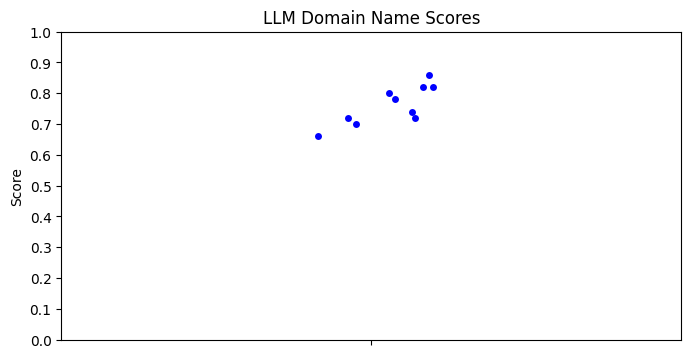

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.stripplot(y=scores, jitter=True, color='blue')
plt.title("LLM Domain Name Scores")
plt.ylabel("Score")
plt.yticks([i/10 for i in range(11)])
plt.show()

In [25]:
model.push_to_hub(
    "pashko-bond/Llama-3.2-3B-domains-iteration-2",
    tokenizer,
    token = userdata.get('HF_TOKEN')
)

README.md:   0%|          | 0.00/598 [00:00<?, ?B/s]

Uploading...:   0%|          | 0.00/48.7M [00:00<?, ?B/s]

Saved model to https://huggingface.co/pashko-bond/Llama-3.2-3B-domains-iteration-2
